## 0. Import dependencies

In [1]:
import os
import sys

import re
import pandas as pd
import networkx as nx
import tqdm
import random
import pickle

# Determine the project root directory for relative imports
try:
    # This will work in scripts where __file__ is defined
    current_dir = os.path.dirname(os.path.abspath(__file__))
    # Assuming "src" is parallel to the script folder
    project_root = os.path.abspath(os.path.join(current_dir, ".."))
except NameError:
    # In notebooks __file__ is not defined: assume we're in notebooks/riziv_dataset/
    project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Local application imports

## 1. Load data

In [2]:
# Define the path to the BSARD dataset files
BSARD_data_path = os.path.join(project_root, "data", "BSARD_dataset")

bsard_corpus = pd.read_csv(os.path.join(BSARD_data_path, 'bsard_corpus.csv'))

In [3]:
bsard_corpus.head(3)

,id,reference,article,law_type,code,book,part,act,chapter,section,subsection,description
0,1,"Art. 1.1.1, Code Bruxellois de l'Air, du Clima...",Le présent Code règle une matière visée à l'ar...,regional,"Code Bruxellois de l'Air, du Climat et de la M...",Dispositions communes,NaN,Généralités,NaN,NaN,NaN,"Dispositions communes, Généralités"
1,2,"Art. 1.1.2, Code Bruxellois de l'Air, du Clima...",Le présent Code transpose en Région de Bruxell...,regional,"Code Bruxellois de l'Air, du Climat et de la M...",Dispositions communes,NaN,Généralités,NaN,NaN,NaN,"Dispositions communes, Généralités"
2,3,"Art. 1.2.1, Code Bruxellois de l'Air, du Clima...",Le présent Code poursuit les objectifs suivant...,regional,"Code Bruxellois de l'Air, du Climat et de la M...",Dispositions communes,NaN,Objectifs,NaN,NaN,NaN,"Dispositions communes, Objectifs"


## 2.

In [4]:
# Patrones para cada sección
PATTERNS = {
    "Book":    re.compile(r"(Livre\s+[^\),]+)"),
    "Title":   re.compile(r"(Titre\s+[^\),]+)"),
    "Chapter": re.compile(r"(Chapitre\s+[^\),]+)"),
    "Section": re.compile(r"(Section\s+[^\),]+)"),
}

def parse_citation(text):
    # 1) Article y Act
    article, rest = [s.strip() for s in text.split(",", 1)]
    # 2) Act (antes de paréntesis) y contenido interno de ()
    act_part, *paren = rest.split("(", 1)
    act = act_part.strip()
    inside = paren[0].rstrip(")") if paren else ""
    # 3) Para cada campo, buscar con su regex
    result = {
        "Article": article,
        "Act": act,
        "Book": None,
        "Title": None,
        "Chapter": None,
        "Section": None,
    }
    for key, pattern in PATTERNS.items():
        m = pattern.search(inside)
        if m:
            result[key] = m.group(1).strip()
    return result

In [5]:
parsed_art = []
parsed_act = []
parsed_book = []
parsed_title = []
parsed_chapter = []
parsed_section = []

for i in bsard_corpus['reference']:
    parsed_citation = parse_citation(i) 
    parsed_art.append(parsed_citation['Article'])
    parsed_act.append(parsed_citation['Act'])
    parsed_book.append(parsed_citation['Book'])
    parsed_title.append(parsed_citation['Title'])
    parsed_chapter.append(parsed_citation['Chapter'])
    parsed_section.append(parsed_citation['Section'])

In [6]:
bsard_corpus['parsed_art'] = parsed_art
bsard_corpus['parsed_act'] = parsed_act
bsard_corpus['parsed_book'] = parsed_book
bsard_corpus['parsed_title'] = parsed_title
bsard_corpus['parsed_chapter'] = parsed_chapter
bsard_corpus['parsed_section'] = parsed_section


In [7]:
bsard_corpus_lean = bsard_corpus[['id', 'parsed_act', 'parsed_book', 'parsed_title', 'parsed_chapter', 'parsed_section', 'parsed_art', 'article']]
bsard_corpus_lean

,id,parsed_act,parsed_book,parsed_title,parsed_chapter,parsed_section,parsed_art,article
0,1,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,None,None,Art. 1.1.1,Le présent Code règle une matière visée à l'ar...
1,2,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,None,None,Art. 1.1.2,Le présent Code transpose en Région de Bruxell...
2,3,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 2,None,None,Art. 1.2.1,Le présent Code poursuit les objectifs suivant...
3,4,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 3,None,None,Art. 1.3.1,"Au sens du présent Code, il faut entendre par ..."
4,5,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 4,Chapitre 1er,None,Art. 1.4.1,"Le plan régional Air-Climat-énergie, ci-après ..."
...,...,...,...,...,...,...,...,...
22628,22629,La Constitution,None,Titre VII,None,None,Art. 194,La ville de Bruxelles est la capitale de la Be...
22629,22630,La Constitution,None,Titre VIII,None,None,Art. 195,Le pouvoir législatif fédéral a le droit de dé...
22630,22631,La Constitution,None,Titre VIII,None,None,Art. 196,Aucune révision de la Constitution ne peut êtr...
22631,22632,La Constitution,None,Titre VIII,None,None,Art. 197,"Pendant une régence, aucun changement ne peut ..."


In [8]:
bsard_corpus_lean['parsed_book'].fillna('not_applicable', inplace=True)
bsard_corpus_lean['parsed_title'].fillna('not_applicable', inplace=True)
bsard_corpus_lean['parsed_chapter'].fillna('not_applicable', inplace=True)
bsard_corpus_lean['parsed_section'].fillna('not_applicable', inplace=True)
bsard_corpus_lean

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17484\4235735230.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bsard_corpus_lean['parsed_book'].fillna('not_applicable', inplace=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17484\4235735230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsard_corpus_lean['parsed_book'].fillna('no

,id,parsed_act,parsed_book,parsed_title,parsed_chapter,parsed_section,parsed_art,article
0,1,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,not_applicable,not_applicable,Art. 1.1.1,Le présent Code règle une matière visée à l'ar...
1,2,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,not_applicable,not_applicable,Art. 1.1.2,Le présent Code transpose en Région de Bruxell...
2,3,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 2,not_applicable,not_applicable,Art. 1.2.1,Le présent Code poursuit les objectifs suivant...
3,4,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 3,not_applicable,not_applicable,Art. 1.3.1,"Au sens du présent Code, il faut entendre par ..."
4,5,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 4,Chapitre 1er,not_applicable,Art. 1.4.1,"Le plan régional Air-Climat-énergie, ci-après ..."
...,...,...,...,...,...,...,...,...
22628,22629,La Constitution,not_applicable,Titre VII,not_applicable,not_applicable,Art. 194,La ville de Bruxelles est la capitale de la Be...
22629,22630,La Constitution,not_applicable,Titre VIII,not_applicable,not_applicable,Art. 195,Le pouvoir législatif fédéral a le droit de dé...
22630,22631,La Constitution,not_applicable,Titre VIII,not_applicable,not_applicable,Art. 196,Aucune révision de la Constitution ne peut êtr...
22631,22632,La Constitution,not_applicable,Titre VIII,not_applicable,not_applicable,Art. 197,"Pendant une régence, aucun changement ne peut ..."


### BOOKS

In [9]:
#bsard_corpus_lean_books = bsard_corpus_lean[bsard_corpus_lean['parsed_book'] != 'not_applicable']
#bsard_corpus_lean_books

In [10]:
#some_dict = {1:2, 3:4}
#act_code_dict["Code Bruxellois de l'Air, du Climat et de la Maîtrise de l'Energie"].append(some_dict)

In [9]:
# All Acts
all_acts = bsard_corpus_lean['parsed_act'].unique()
act_code_dict = {act: [i+1] for i, act in enumerate(all_acts)}
for act in all_acts:
    tmp_act_df = bsard_corpus_lean[bsard_corpus_lean['parsed_act'] == act]

    
    # All Books
    all_books = tmp_act_df['parsed_book'].unique()
    book_code_dict = {book: [i+1] for i, book in enumerate(all_books)}
    book_code_dict['not_applicable'] = [0]
    for book in all_books:
        tmp_book_df = tmp_act_df[tmp_act_df['parsed_book'] == book]

        act_code_dict[act].append(book_code_dict)
        
        # All Titles
        all_titles = tmp_book_df['parsed_title'].unique()
        title_code_dict = {title: [i+1] for i, title in enumerate(all_titles)}
        title_code_dict['not_applicable'] = [0]
        for title in all_titles:
            tmp_title_df = tmp_book_df[tmp_book_df['parsed_title'] == title]

            book_code_dict[book].append(title_code_dict)
            
        #    # All Chapters
        #    all_chapters = tmp_title_df['parsed_chapter'].unique()
        #    chapter_code_dict = {chapter: [i+1] for i, chapter in enumerate(all_chapters)}
        #    chapter_code_dict['not_applicable'] = [0]
        #    for chapter in all_chapters:
        #        tmp_chapter_df = tmp_title_df[tmp_title_df['parsed_chapter'] == chapter]
        #
        #        title_code_dict[title].append(chapter_code_dict)
        #       
        #        # All Sections
        #        all_sections = tmp_chapter_df['parsed_section'].unique()
        #        section_code_dict = {section: [i+1] for i, section in enumerate(all_sections)}
        #        section_code_dict['not_applicable'] = [0]
        #        for section in all_sections:
        #            tmp_section_df = tmp_chapter_df[tmp_chapter_df['parsed_section'] == section]
        #
        #            chapter_code_dict[chapter].append(section_code_dict)
        #
        #            # All Articles
        #            all_articles = tmp_section_df['parsed_art'].unique()
        #            for article in all_articles:
        #                tmp_article_df = tmp_section_df[tmp_section_df['parsed_art'] == article]


            # All Articles
            all_articles = tmp_title_df['parsed_art'].unique()
            article_code_dict = {article: [i+1] for i, article in enumerate(all_articles)}
            for article in all_articles:
                tmp_article_df = tmp_title_df[tmp_title_df['parsed_art'] == article]

                title_code_dict[title].append(article_code_dict)


In [10]:
act_code = []
book_code = []
title_code = []
chapter_code = []
#article_code = []
#section_code = []
article_code = []

for row in bsard_corpus_lean.iterrows():
    #print(row[1])
    row_act_code = act_code_dict[row[1]['parsed_act']][0]
    act_code.append(str(row_act_code))

    row_book_code = act_code_dict[row[1]['parsed_act']][1][row[1]['parsed_book']][0]
    book_code.append(str(row_act_code)+'.'+str(row_book_code))

    row_title_code = act_code_dict[row[1]['parsed_act']][1][row[1]['parsed_book']][1][row[1]['parsed_title']][0]
    title_code.append(str(row_act_code)+'.'+str(row_book_code)+'.'+str(row_title_code))

#    row_chapter_code = act_code_dict[row[1]['parsed_act']][1][row[1]['parsed_book']][1][row[1]['parsed_title']][1][row[1]['parsed_chapter']][0]
#    chapter_code.append(str(row_act_code)+'.'+str(row_book_code)+'.'+str(row_title_code)+'.'+str(row_chapter_code))
#
#    row_section_code = act_code_dict[row[1]['parsed_act']][1][row[1]['parsed_book']][1][row[1]['parsed_title']][1][row[1]['parsed_chapter']][1][row[1]['parsed_section']][0]    
#    section_code.append(str(row_act_code)+'.'+str(row_book_code)+'.'+str(row_title_code)+'.'+str(row_chapter_code)+'.'+str(row_section_code))

    row_article_code = act_code_dict[row[1]['parsed_act']][1][row[1]['parsed_book']][1][row[1]['parsed_title']][1][row[1]['parsed_art']][0]
    article_code.append(str(row_act_code)+'.'+str(row_book_code)+'.'+str(row_title_code)+'.'+str(row_article_code))

bsard_corpus_lean['act_code'] = act_code
bsard_corpus_lean['book_code'] = book_code
bsard_corpus_lean['title_code'] = title_code
#bsard_corpus_lean['chapter_code'] = chapter_code
#bsard_corpus_lean['section_code'] = section_code
bsard_corpus_lean['article_code'] = article_code


C:\Users\Usuario\AppData\Local\Temp\ipykernel_17484\1371738312.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsard_corpus_lean['act_code'] = act_code
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17484\1371738312.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsard_corpus_lean['book_code'] = book_code
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17484\1371738312.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [11]:
bsard_corpus_lean

,id,parsed_act,parsed_book,parsed_title,parsed_chapter,parsed_section,parsed_art,article,act_code,book_code,title_code,article_code
0,1,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,not_applicable,not_applicable,Art. 1.1.1,Le présent Code règle une matière visée à l'ar...,1,1.1,1.1.1,1.1.1.1
1,2,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,not_applicable,not_applicable,Art. 1.1.2,Le présent Code transpose en Région de Bruxell...,1,1.1,1.1.1,1.1.1.2
2,3,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 2,not_applicable,not_applicable,Art. 1.2.1,Le présent Code poursuit les objectifs suivant...,1,1.1,1.1.2,1.1.2.1
3,4,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 3,not_applicable,not_applicable,Art. 1.3.1,"Au sens du présent Code, il faut entendre par ...",1,1.1,1.1.3,1.1.3.1
4,5,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 4,Chapitre 1er,not_applicable,Art. 1.4.1,"Le plan régional Air-Climat-énergie, ci-après ...",1,1.1,1.1.4,1.1.4.1
...,...,...,...,...,...,...,...,...,...,...,...,...
22628,22629,La Constitution,not_applicable,Titre VII,not_applicable,not_applicable,Art. 194,La ville de Bruxelles est la capitale de la Be...,35,35.0,35.0.9,35.0.9.8
22629,22630,La Constitution,not_applicable,Titre VIII,not_applicable,not_applicable,Art. 195,Le pouvoir législatif fédéral a le droit de dé...,35,35.0,35.0.10,35.0.10.1
22630,22631,La Constitution,not_applicable,Titre VIII,not_applicable,not_applicable,Art. 196,Aucune révision de la Constitution ne peut êtr...,35,35.0,35.0.10,35.0.10.2
22631,22632,La Constitution,not_applicable,Titre VIII,not_applicable,not_applicable,Art. 197,"Pendant une régence, aucun changement ne peut ...",35,35.0,35.0.10,35.0.10.3


In [14]:
#G = nx.DiGraph()
#
#for act in bsard_corpus_lean['act_code'].unique():
#    if act != "35":
#        continue
#
#    G.add_node(act, node_type="Act", act_title=bsard_corpus_lean[bsard_corpus_lean['act_code'] == act]['parsed_act'].unique()[0])
#
#    # Book level
#    sub_book_df = bsard_corpus_lean[bsard_corpus_lean['act_code'] == act]
#
#    # If there are no books...
#    if sub_book_df['parsed_book'].unique().size == 1 and sub_book_df['parsed_book'].unique()[0] == "not_applicable":
#
#        # Title level - no books
#        sub_title_df = sub_book_df[sub_book_df['book_code'] == book]
#
#        # If there are no books and no titles...
#        if sub_title_df['title_code'].unique().size == 1 and sub_title_df['title_code'].unique()[0] == "not_applicable":
#
#            # Article level - no books and no titles -> Articles link directly to the Act
#            sub_article_df = sub_title_df[sub_title_df['article_code'] == article]
#            for article in sub_article_df['article_code'].unique():
#                G.add_node(article, node_type="Article")
#                G.add_edge(act, article, relation="contains")
#                G.add_edge(article, act, relation="belongs_to")
#
#        # If there are titles...
#        else:
#
#            # Titles link directly to the Act
#            for title in sub_title_df['title_code'].unique():
#                G.add_node(title, node_type="Title")
#                G.add_edge(act, title, relation="contains")
#                G.add_edge(title, act, relation="belongs_to")
#
#            sub_article_df = sub_title_df[sub_title_df['title_code'] == title]
#            for article in sub_article_df['article_code'].unique():
#                G.add_node(article, node_type="Article")
#                G.add_edge(title, article, relation="contains")
#                G.add_edge(article, title, relation="belongs_to")
#
#    # If there are books...
#    else:
#
#        # Books link directly to the Act
#        for book in sub_book_df['book_code'].unique():
#            G.add_node(book, node_type="Book")
#            G.add_edge(act, book, relation="contains")
#            G.add_edge(book, act, relation="belongs_to")
#
#
#        # Title level - books
#        sub_title_df = sub_book_df[sub_book_df['book_code'] == book]
#
#        # If there are books and no titles...
#        if sub_title_df['title_code'].unique().size == 1 and sub_title_df['title_code'].unique()[0] == "not_applicable":
#
#            # Article level - books and no titles -> Articles link directly to the Book
#            sub_article_df = sub_title_df[sub_title_df['title_code'] == title]
#            for article in sub_article_df['article_code'].unique():
#                G.add_node(article, node_type="Article")
#                G.add_edge(book, article, relation="contains")
#                G.add_edge(article, book, relation="belongs_to")
#
#        # If there are titles...
#        else:
#
#            # Titles link directly to the Book
#            for title in sub_title_df['title_code'].unique():
#                G.add_node(title, node_type="Title")
#                G.add_edge(book, title, relation="contains")
#                G.add_edge(title, book, relation="belongs_to")
#
#                # Article level - books and titles -> Articles link directly to the Title
#                sub_article_df = sub_title_df[sub_title_df['title_code'] == title]
#                for article in sub_article_df['article_code'].unique():
#                    G.add_node(article, node_type="Article")
#                    G.add_edge(title, article, relation="contains")
#                    G.add_edge(article, title, relation="belongs_to")

In [13]:
# Nota importante: no se quitan los nodos de "not_applicable"...

G = nx.DiGraph()

G.add_node("Meta", node_type="Meta")

for act in bsard_corpus_lean['act_code'].unique():
    # Solo ejemplo para un act; quita este if si quieres procesarlos todos
    #if act != "35":
    #    continue

    df_act = bsard_corpus_lean[bsard_corpus_lean['act_code'] == act]
    act_title = df_act['parsed_act'].iloc[0]
    G.add_node(act, node_type="Act", act_title=act_title)
    G.add_edge(act, "Meta", relation="contains")
    G.add_edge("Meta", act, relation="belongs_to")

    # Nivel Books
    books = [b for b in df_act['book_code'].unique() if b != 'not_applicable']
    if books:
        # Hay libros
        for book in books:
            df_book = df_act[df_act['book_code'] == book]
            G.add_node(book, node_type="Book")
            G.add_edge(act, book, relation="contains")
            G.add_edge(book, act, relation="belongs_to")

            # Nivel Titles dentro de cada libro
            titles = [t for t in df_book['title_code'].unique() if t != 'not_applicable']
            if titles:
                for title in titles:
                    df_title = df_book[df_book['title_code'] == title]
                    G.add_node(title, node_type="Title")
                    G.add_edge(book, title, relation="contains")
                    G.add_edge(title, book, relation="belongs_to")

                    # Final: Artículos bajo cada título
                    for article in df_title['article_code'].unique():
                        G.add_node(article, node_type="Article", text=df_act[df_act['article_code'] == article]['article'].iloc[0])
                        G.add_edge(title, article, relation="contains")
                        G.add_edge(article, title, relation="belongs_to")
            else:
                # No hay títulos: los artículos van directamente al libro
                for article in df_book['article_code'].unique():
                    G.add_node(article, node_type="Article", text=df_act[df_act['article_code'] == article]['article'].iloc[0])
                    G.add_edge(book, article, relation="contains")
                    G.add_edge(article, book, relation="belongs_to")
    else:
        # No hay libros: trabajamos a nivel del Act
        titles = [t for t in df_act['title_code'].unique() if t != 'not_applicable']
        if titles:
            # Títulos directos del Act
            for title in titles:
                df_title = df_act[df_act['title_code'] == title]
                G.add_node(title, node_type="Title")
                G.add_edge(act, title, relation="contains")
                G.add_edge(title, act, relation="belongs_to")

                # Artículos bajo cada título
                for article in df_title['article_code'].unique():
                    G.add_node(article, node_type="Article", text=df_act[df_act['article_code'] == article]['article'].iloc[0])
                    G.add_edge(title, article, relation="contains")
                    G.add_edge(article, title, relation="belongs_to")
        else:
            # Ni libros ni títulos: artículos directos del Act
            for article in df_act['article_code'].unique():
                G.add_node(article, node_type="Article", text=df_act[df_act['article_code'] == article]['article'].iloc[0])
                G.add_edge(act, article, relation="contains")
                G.add_edge(article, act, relation="belongs_to")


In [14]:
import networkx as nx

G = nx.DiGraph()

G.add_node("Meta", node_type="Meta")

for act in bsard_corpus_lean['act_code'].unique():
    # Quita este filtro para procesar todos los acts
    # if act != "35":
    #     continue

    df_act = bsard_corpus_lean[bsard_corpus_lean['act_code'] == act]
    act_title = df_act['parsed_act'].iloc[0]
    G.add_node(act, node_type="Act", act_title=act_title)
    G.add_edge(act, "Meta", relation="contains")
    G.add_edge("Meta", act, relation="belongs_to")

    # --- Nivel Books ---
    books = [b for b in df_act['book_code'].unique() if b != 'not_applicable']
    if books:
        for book in books:
            df_book = df_act[df_act['book_code'] == book]
            G.add_node(book, node_type="Book")
            G.add_edge(act, book, relation="contains")
            G.add_edge(book, act, relation="belongs_to")

            # --- Nivel Titles dentro de cada Book ---
            titles = [t for t in df_book['title_code'].unique() if t != 'not_applicable']
            if titles:
                for title in titles:
                    df_title = df_book[df_book['title_code'] == title]
                    G.add_node(title, node_type="Title")
                    G.add_edge(book, title, relation="contains")
                    G.add_edge(title, book, relation="belongs_to")

                    # Artículos bajo cada Title, con enlaces "precedes"/"succeeds"
                    prev_article = None
                    for article in df_title['article_code'].unique():
                        G.add_node(article, node_type="Article", text=df_act[df_act['article_code'] == article]['article'].iloc[0])
                        G.add_edge(title, article, relation="contains")
                        G.add_edge(article, title, relation="belongs_to")
                        if prev_article is not None:
                            G.add_edge(prev_article, article, relation="precedes")
                            G.add_edge(article, prev_article, relation="succeeds")
                        prev_article = article
            else:
                # No hay Titles → Articles directos al Book
                prev_article = None
                for article in df_book['article_code'].unique():
                    G.add_node(article, node_type="Article", text=df_act[df_act['article_code'] == article]['article'].iloc[0])
                    G.add_edge(book, article, relation="contains")
                    G.add_edge(article, book, relation="belongs_to")
                    if prev_article is not None:
                        G.add_edge(prev_article, article, relation="precedes")
                        G.add_edge(article, prev_article, relation="succeeds")
                    prev_article = article
    else:
        # No hay Books → nivel Title/Article directo de Act
        titles = [t for t in df_act['title_code'].unique() if t != 'not_applicable']
        if titles:
            for title in titles:
                df_title = df_act[df_act['title_code'] == title]
                G.add_node(title, node_type="Title")
                G.add_edge(act, title, relation="contains")
                G.add_edge(title, act, relation="belongs_to")

                # Artículos bajo cada Title
                prev_article = None
                for article in df_title['article_code'].unique():
                    G.add_node(article, node_type="Article", text=df_act[df_act['article_code'] == article]['article'].iloc[0])
                    G.add_edge(title, article, relation="contains")
                    G.add_edge(article, title, relation="belongs_to")
                    if prev_article is not None:
                        G.add_edge(prev_article, article, relation="precedes")
                        G.add_edge(article, prev_article, relation="succeeds")
                    prev_article = article
        else:
            # Ni Books ni Titles → Articles directos al Act
            prev_article = None
            for article in df_act['article_code'].unique():
                G.add_node(article, node_type="Article", text=df_act[df_act['article_code'] == article]['article'].iloc[0])
                G.add_edge(act, article, relation="contains")
                G.add_edge(article, act, relation="belongs_to")
                if prev_article is not None:
                    G.add_edge(prev_article, article, relation="precedes")
                    G.add_edge(article, prev_article, relation="succeeds")
                prev_article = article


In [15]:
import matplotlib.pyplot as plt

def visualize_node_1hop(G: nx.DiGraph, node_id: str, figsize=(12, 8)):
    """
    Visualize a node and its 1‑hop neighborhood in a hierarchy graph.

    Nodes are colored by their 'level' attribute:
      - Central node: red
      - Act: gold
      - Book: orange
      - Title: lightblue
      - Chapter: green
      - Section: teal
      - Article: purple

    Edges are drawn and labeled according to their 'relation' attribute:
      - CONTAINS: black, label="contains"
      - BELONGS_TO: gray, label="belongs to"
    """
    # Gather the node and its immediate predecessors & successors
    preds = list(G.predecessors(node_id))
    succs = list(G.successors(node_id))
    sub_nodes = {node_id, *preds, *succs}
    subG = G.subgraph(sub_nodes)

    plt.figure(figsize=figsize)
    # Force a consistent layout for clarity
    pos = nx.spring_layout(subG, k=1.0, iterations=50, seed=42)

    # Color mapping for levels
    level_colors = {
        "Act": "gold",
        "Book": "orange",
        "Title": "lightblue",
        "Chapter": "green",
        "Section": "teal",
        "Article": "purple"
    }

    # Draw all nodes, colored by level
    for level, color in level_colors.items():
        nodes_of_level = [
            n for n, attrs in subG.nodes(data=True)
            if attrs.get("level") == level and n != node_id
        ]
        nx.draw_networkx_nodes(
            subG, pos,
            nodelist=nodes_of_level,
            node_color=color,
            node_size=1200,
            label=level
        )

    # Draw the central node on top
    nx.draw_networkx_nodes(
        subG, pos,
        nodelist=[node_id],
        node_color="red",
        node_size=1500,
        label="Central"
    )

    # Draw edges by relation type
    relation_styles = {
        "CONTAINS":    {"color": "black", "label": "contains"},
        "BELONGS_TO":  {"color": "gray",  "label": "belongs to"}
    }
    # We'll collect labels separately so they don't overlap too badly
    edge_labels = {}

    for (u, v, attrs) in subG.edges(data=True):
        rel = attrs.get("relation")
        style = relation_styles.get(rel, {})
        nx.draw_networkx_edges(
            subG, pos,
            edgelist=[(u, v)],
            edge_color=style.get("color", "black"),
            arrows=True,
            arrowsize=20,
            connectionstyle="arc3,rad=0.1"
        )
        # position label near the middle of the edge
        edge_labels[(u, v)] = style.get("label", rel.lower())

    # Draw edge labels
    nx.draw_networkx_edge_labels(
        subG, pos,
        edge_labels=edge_labels,
        font_size=9,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7),
        label_pos=0.5
    )

    # Draw node labels (just show the node_id or you could use attrs['label'])
    labels = {n: n.split("|", 1)[-1] for n in subG.nodes()}
    nx.draw_networkx_labels(subG, pos, labels, font_size=8)

    # Add a legend for node colors
    handles = []
    for level, color in level_colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                  label=level,
                                  markerfacecolor=color, markersize=10))
    handles.append(plt.Line2D([0], [0], marker='o', color='w',
                              label="Central", markerfacecolor='red', markersize=10))
    plt.legend(handles=handles, loc="upper left", bbox_to_anchor=(1, 1))

    plt.title(f"1‑hop neighborhood of node: {node_id}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [16]:
G.nodes['18.0.7.15']

{'node_type': 'Article',
 'text': "L'Agence wallonne pour la Promotion d'une Agriculture de qualité instituée à l'article D.224 est chargée de la promotion des produits de qualité différenciée."}

In [20]:
list(G.neighbors('Meta'))


['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35']

In [21]:
bsard_corpus_lean[bsard_corpus_lean['article_code'] == '18.0.7.15']


,id,parsed_act,parsed_book,parsed_title,parsed_chapter,parsed_section,parsed_art,article,act_code,book_code,title_code,article_code
11055,11056,Code Wallon de l'Agriculture,not_applicable,Titre VII,Chapitre II,not_applicable,Art. D.184,L'Agence wallonne pour la Promotion d'une Agri...,18,18.0,18.0.7,18.0.7.15


Randomly selected node: 12.2.12


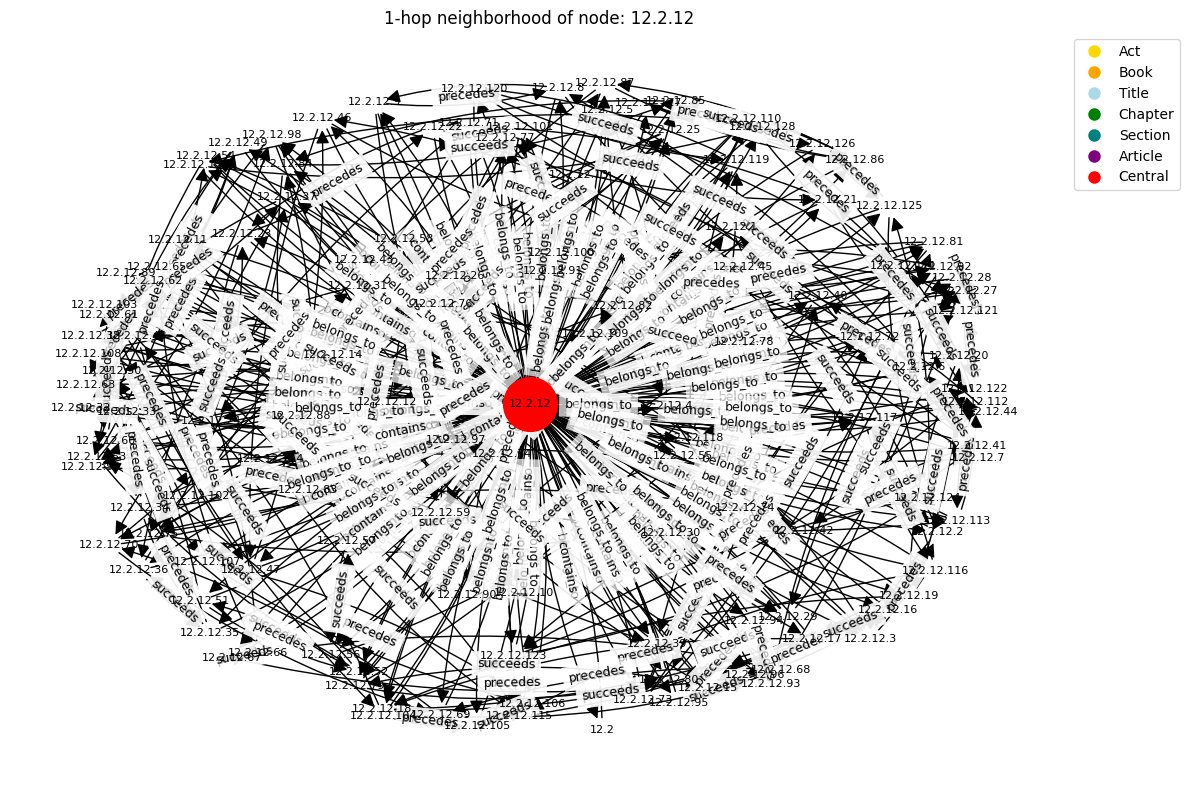

In [23]:
# Select a random node from the graph
random_node = random.choice(list(G.nodes()))
#print(f"node type: {G.nodes[random_node]['node_type']}")

while G.nodes[random_node]['node_type'] == 'Article':
    #print(f"node type: {G.nodes[random_node]['node_type']}")
    random_node = random.choice(list(G.nodes()))

# Print it (so you know which one it is), then visualize its 1‑hop neighborhood
print(f"Randomly selected node: {random_node}")
visualize_node_1hop(G, random_node)

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_node_2hop(G: nx.DiGraph, node_id: str, figsize=(15, 10)):
    """
    Visualize a node, its 1‑hop and 2‑hop neighbors in a hierarchy graph.

    Nodes are colored by their 'level' attribute:
      - Central node: red
      - Act: gold
      - Book: orange
      - Title: lightblue
      - Chapter: green
      - Section: teal
      - Article: purple

    Edges are drawn and labeled according to their 'relation' attribute:
      - CONTAINS: black, label="contains"
      - BELONGS_TO: gray, label="belongs to"
    """
    # 1-hop neighbors
    first_hop = set(G.predecessors(node_id)) | set(G.successors(node_id))
    # 2-hop neighbors
    second_hop = set()
    for nbr in first_hop:
        second_hop |= set(G.predecessors(nbr))
        second_hop |= set(G.successors(nbr))
    # exclude the central node and 1-hop from 2-hop
    second_hop -= first_hop
    second_hop.discard(node_id)

    # Build subgraph of central + 1-hop + 2-hop
    sub_nodes = {node_id} | first_hop | second_hop
    subG = G.subgraph(sub_nodes)

    plt.figure(figsize=figsize)
    pos = nx.spring_layout(subG, k=1.5, iterations=50, seed=42)

    # Color mapping for levels
    level_colors = {
        "Act": "gold",
        "Book": "orange",
        "Title": "lightblue",
        "Chapter": "green",
        "Section": "teal",
        "Article": "purple"
    }

    # Draw 2-hop neighbors (smaller)
    two_hop_nodes = [n for n in second_hop]
    nx.draw_networkx_nodes(
        subG, pos,
        nodelist=two_hop_nodes,
        node_color=[level_colors.get(subG.nodes[n].get("level"), "gray") for n in two_hop_nodes],
        node_size=600,
        alpha=0.5,
        label="2-hop"
    )

    # Draw 1-hop neighbors
    one_hop_nodes = [n for n in first_hop]
    nx.draw_networkx_nodes(
        subG, pos,
        nodelist=one_hop_nodes,
        node_color=[level_colors.get(subG.nodes[n].get("level"), "gray") for n in one_hop_nodes],
        node_size=1200,
        alpha=0.8,
        label="1-hop"
    )

    # Draw central node last (on top)
    nx.draw_networkx_nodes(
        subG, pos,
        nodelist=[node_id],
        node_color="red",
        node_size=2000,
        label="Central"
    )

    # Draw edges
    rel_styles = {
        "CONTAINS":   {"color": "black", "label": "contains"},
        "BELONGS_TO": {"color": "gray",  "label": "belongs to"}
    }
    edge_labels = {}
    for u, v, attrs in subG.edges(data=True):
        rel = attrs.get("relation")
        style = rel_styles.get(rel, {"color": "black", "label": rel.lower()})
        nx.draw_networkx_edges(
            subG, pos,
            edgelist=[(u, v)],
            edge_color=style["color"],
            arrows=True,
            arrowsize=15,
            connectionstyle="arc3,rad=0.1"
        )
        edge_labels[(u, v)] = style["label"]

    # Draw edge labels
    nx.draw_networkx_edge_labels(
        subG, pos,
        edge_labels=edge_labels,
        font_size=8,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7),
        label_pos=0.5
    )

    # Node labels: show just the value part (after the first '|')
    labels = {n: n.split("|", 1)[-1] for n in subG.nodes()}
    nx.draw_networkx_labels(subG, pos, labels, font_size=8)

    # Build legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Central',   markerfacecolor='red',        markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='1-hop',     markerfacecolor='lightgray', markersize=8, alpha=0.8),
        plt.Line2D([0], [0], marker='o', color='w', label='2-hop',     markerfacecolor='lightgray', markersize=6, alpha=0.5),
    ]
    for level, color in level_colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                  label=level, markerfacecolor=color, markersize=8))
    plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

    plt.title(f"2‑hop neighborhood of node: {node_id}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Randomly selected node: 25.11.1.5


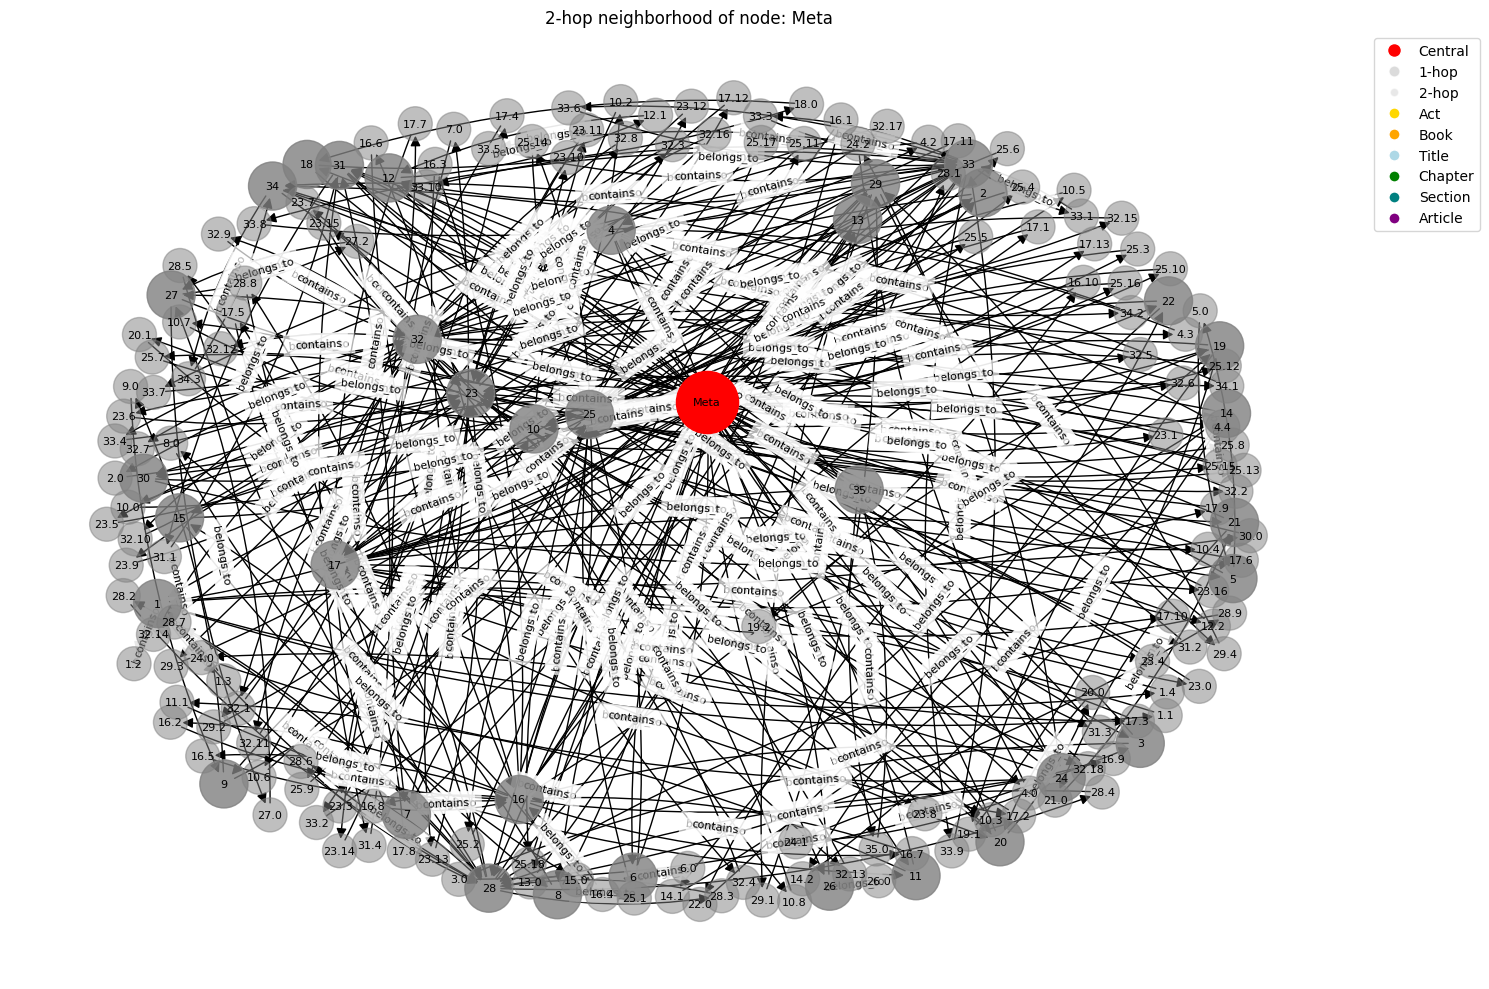

In [26]:


# Select a random node from the graph
random_node = random.choice(list(G.nodes()))

# Print it (so you know which one it is), then visualize its 1‑hop neighborhood
print(f"Randomly selected node: {random_node}")
visualize_node_2hop(G, "Meta")

## 3.

In [27]:
import pickle

with open(os.path.join(BSARD_data_path, "base_document_graph_V2.pkl"), 'wb') as f:
    pickle.dump(G, f)

In [25]:
bsard_corpus_lean.to_csv(os.path.join(BSARD_data_path, "bsard_corpus_lean_V2.csv"))